# Import relevant libraries

In [1]:
import os
import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import rc, rcParams
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

# Setup

In [2]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

In [3]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

In [4]:
# set font
rc('font', **{'family': 'sans-serif', 'sans-serif':['Avant Garde']})
rc('text', usetex=True)

# Load data

In [5]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [6]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [7]:
fee_age = perf_eval_df[['age', 'fee_cleaned']]
fee_age

,age,fee_cleaned
0,19.0,0.817
1,21.0,0.013
2,25.0,1.170
3,21.0,0.005
4,19.0,0.817
...,...,...
26589,25.0,2.250
26590,23.0,4.500
26591,23.0,0.450
26592,28.0,2.480


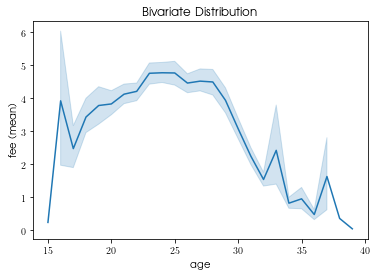

In [8]:
# the variance is quite high
fig, ax = plt.subplots(figsize = (6, 4))
ax = sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.mean, ci = 95)
ax.set(xlabel='age', ylabel = 'fee (mean)')
ax.set_title('Bivariate Distribution')

# save plot
path = os.path.join('output', 'fee_age_bivar.png')
plt.savefig(path)

plt.show()

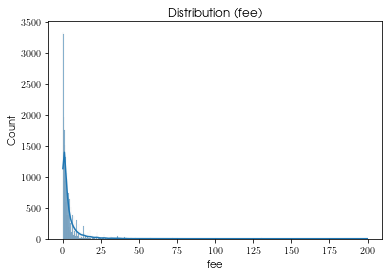

In [9]:
# heavy-tailed distribution --> median would be a more sensible mid-point measure
# as mean would be influenced by the outliers
fig, ax = plt.subplots(figsize = (6, 4))
ax = sns.histplot(fee_age['fee_cleaned'], kde = True)
ax.set(xlabel='fee')
ax.set_title('Distribution (fee)')

# save plot
path = os.path.join('output', 'fee_hist.png')
plt.savefig(path)

plt.show()

In [10]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned']\
                   .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 100]

In [11]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

,mean,median,std,min,max,count
age,,,,,,
17.0,2.476510,0.990,3.844370,0.005,21.60,145
18.0,3.433969,1.350,6.202667,0.002,40.50,512
19.0,3.783434,1.350,9.608391,0.005,130.50,1052
20.0,3.830943,1.580,7.183568,0.009,124.20,1605
21.0,4.126564,1.530,7.276784,0.005,79.38,2169
22.0,4.212821,1.620,6.906991,0.004,67.50,2549
23.0,4.760516,1.980,8.301757,0.009,94.50,2802
24.0,4.775991,1.980,8.126826,0.008,90.90,2771
25.0,4.769627,2.120,9.505160,0.009,199.80,2594


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


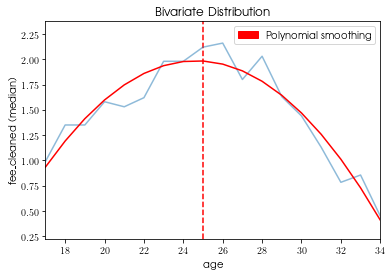

In [12]:
# visualize
fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, ci = None, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (min(desc_stat['median']*0.5), max(desc_stat['median'])*1.1)

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

# smoothen the liner
fit = np.polyfit(x, y, deg = 2)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')
dca_patch = mpatches.Patch(color='red', label='Polynomial smoothing')
ax.legend(handles=[dca_patch], bbox_to_anchor = (1, 1))

# get the turning point (slope < 0)
idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0]

# add vertical line at the turning point
plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

ax.set(xlabel='age', ylabel = 'fee\_cleaned (median)')
ax.set_title('Bivariate Distribution')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# save plot
path = os.path.join('output', 'poly_smooth.png')
plt.savefig(path)

plt.show()

In [13]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index,
                               'coef': coef})
temp_df

,age,coef
0,17.0,1.000000
1,18.0,0.784209
2,19.0,0.661457
3,20.0,0.584819
4,21.0,0.534897
5,22.0,0.502366
6,23.0,0.482366
7,24.0,0.472339
8,25.0,0.471119
9,26.0,0.478570


In [14]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.784209
4,19.0,0.661457
5,20.0,0.584819
6,21.0,0.534897
7,22.0,0.502366
8,23.0,0.482366
9,24.0,0.472339


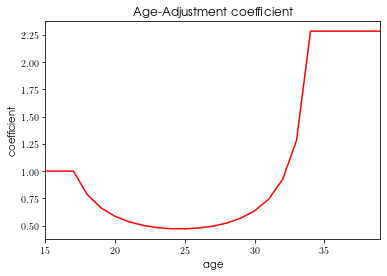

In [15]:
# visualize
fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data = adj_coef_table, x = 'age', y = 'coef', color = 'red')

ax.set(xlabel='age', ylabel = 'coefficient')
ax.set_title('Age-Adjustment coefficient')

xlim = (min(adj_coef_table['age']), max(adj_coef_table['age']))
ax.set_xlim(xlim)

# save plot
path = os.path.join('output', 'adj_coef.png')
plt.savefig(path)

plt.show()

## Homophily Analysis

In [16]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


### Create structured data

In [17]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_name'].unique())

In [18]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [19]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):

    if prev_year in nested_dict.keys():

        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])

    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}

    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]

    # subset for transfer_movement == 'in', 'out'
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']

    # loop over club:
    for club in club_list:

        # subset data by club
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]

        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])

        if prev_year in nested_dict.keys():

            # catch bug (The case when club has no member yet)
            if club_member[club] is None:
                club_member[club] = []

            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)

        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in,
                                                    player_list_out)

    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member

    # set previous year
    prev_year = year

### Analysis

In [20]:
# subset only `transfer_movement` == 'in'; we want to analyze the number of ties a player has
# before entering a team
df = node_edge_df[node_edge_df['transfer_movement'] == 'in']
df.reset_index(drop=True, inplace=True)
# clean the table
df.drop_duplicates(inplace=True)

In [21]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(
    np.max)
df.drop(columns='count', inplace=True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 78625


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992,1,1
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992,1,1
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992,1,1
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992,1,2
4,Dordrecht'90,Michel Langerak,23.0,Attacking Midfield,VVV-Venlo,?,in,NaN,1992,1,3


In [22]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

Number of players: 28976
Number of clubs: 401


In [23]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):

    # subset df by player
    temp_df = df[df['player_name'] == player]

    # reset_index
    temp_df.reset_index(drop=True, inplace=True)

    # initiate inside dictionaries
    aff_clubs = {}
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """

    for row in range(len(temp_df) - 1):

        # initiate inside dictionaries
        year_member = {}

        club_name = temp_df.iloc[row]['club_name']

        year_list = np.arange(temp_df.iloc[row]['year'],
                              temp_df.iloc[row + 1]['year'])

        # get the affiliated player each year from `nested_dict`
        for year in year_list:

            # just in case some years are missing
            if year not in nested_dict.keys():

                pass

            else:

                aff_players = nested_dict[year][club_name]

                # add data to `year_member`
                year_member[year] = aff_players

        # add data to aff_club

        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():

            aff_clubs[club_name].update(year_member)

        else:

            aff_clubs[club_name] = year_member

    # add data to was_in
    was_in[player] = aff_clubs

In [24]:
# was_in

In [25]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 78625


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2


In [26]:
# generate `k` column

# initiate a list
k = []
k_names = []

# loop over the dataset
for i in tqdm(range(len(df))):

    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:

        k.append(None)
        k_names.append([])

    else:

        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i - 1]
        club = df['club_name'][i]
        prev_year = df['year'][i - 1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)

        # get all the affiliated players
        aff_players = []
        for year in year_range:

            # just in case some years are missing
            if year not in nested_dict.keys():

                pass

            else:

                aff_player = was_in[player][prev_club][year]
                aff_players.extend(aff_player)

        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]

        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))

        # get `k_names`, `k_val`
        k_name = list(
            set.intersection(set(aff_players), set(in_club_player)) -
            set([player]))
        k_val = len(k_name)

        # append data
        k_names.append(k_name)
        k.append(k_val)

        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k
# add `k_name` column
df['k_name'] = k_names

In [27]:
# get k-pk table
k_count = df[['k']].dropna()
k_count['count'] = 1
k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
k_count.reset_index(inplace=True)
k_count['pk'] = k_count['count'] / sum(k_count['count'])

k_pk = k_count
# hardcode: few `k` is enough to investigate the existence of homophily
xmax = 7
k_pk = k_pk[k_pk['k'] <= xmax]
k_pk

,k,count,pk
0,0.0,19685,0.396483
1,1.0,7430,0.149651
2,2.0,3280,0.066064
3,3.0,1505,0.030313
4,4.0,751,0.015126
5,5.0,462,0.009305
6,6.0,338,0.006808
7,7.0,311,0.006264


### Visualization

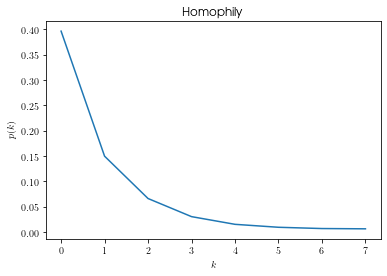

In [28]:
# plot k-p(k) -- probability of a player joining a team with k-friends
fig, ax = plt.subplots(figsize = (6, 4))
ax = sns.lineplot(data = k_pk, x = 'k', y = 'pk')
ax.set(xlabel='$k$', ylabel = '$p(k)$')
ax.set_title('Homophily')

# save plot
path = os.path.join('output', 'homophily.png')
plt.savefig(path)

plt.show()

### Test the existence of homophily

#### Null case simulation
In this section, we simulated 10 random networks for the football data. Here are some important features:
1) The simulated data follow the same proportion of the number of transfers by players in the network  
2) The simulated data assume players only transfer within the 8 major leagues and are always in a club until 2020 (No retire or without club)

In [29]:
# # load data
# node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))

In [30]:
# #select only necessary columns
# data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]

In [31]:
# data_simul

In [32]:
# len(data_simul)

In [33]:
# # set-up

# player_name_list = data_simul['player_name'].unique()
# club_name_list = data_simul['club_name'].unique()
# year_list = data_simul['year'].unique()

# # in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
# in_num = sum(data_simul['transfer_movement'] == 'in')

# # number of movement distribution
# num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
# num_move['count'] = 1
# num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
# num_move = pd.DataFrame(num_move).reset_index()
# num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
# num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
# num_move = num_move / np.sum(num_move)
# num_move = round(num_move * in_num)
# num_move = pd.DataFrame(num_move).reset_index()

In [34]:
# num_move

In [35]:
# # get column names
# col_names = data_simul.columns

# # simulate data
# rows = []
# for t, count in zip(num_move['transfer_movement'], num_move['count']):
#     for i in tqdm(range(int(count))):
#         # get each column value
#         player_name = np.repeat(np.random.choice(player_name_list, 1), t)
#         club_name = np.random.choice(club_name_list, t, replace = False)
#         transfer_movement = np.repeat('in', t)
#         year = np.random.choice(year_list, t, replace = False)
#         # format data
#         row = list(zip(player_name, club_name, transfer_movement, year))
#         # add to the list
#         rows.extend(row)

# # create dataframe
# null_case = pd.DataFrame(data = rows, columns = col_names)
# print(f'number of observation: {len(null_case)}')
# null_case.head()

In [36]:
# # sort data
# null_case = null_case.sort_values(by = ['player_name', 'year'])

# # add column `num_transfer` which represent the number of time a player moved
# null_case['count'] = 1
# null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
# null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
# null_case.drop(columns = 'count', inplace = True)
# null_case.reset_index(drop = True, inplace = True)
# print(f'number of observation: {len(null_case)}')
# null_case

In [37]:
# # add `transfer_movement` == 'out'
# to_add = []
# for i in tqdm(range(len(null_case))):
#     if (null_case.iloc[i]['num_transfer'] > 1) & \
#     (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
#         # create the 'out' case
#         row = list(null_case.iloc[i].replace('in', 'out'))
#         # add to `to_add` list
#         to_add.append(row)

# # add data to dataframe
# extend = pd.DataFrame(data = to_add, columns = null_case.columns)
# null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
# null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
# null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)
# null_case

#### Null case analysis

In [38]:
# # 2 components needed: 'year_list', 'club_list'
# year_list = sorted(sorted(null_case['year'].unique()))
# club_list = sorted(null_case['club_name'].unique())

In [39]:
# # nested dictionary: year: `club_member`
# nested_dict = {}
# prev_year = None

# # loop over year:
# for year in tqdm(year_list):

#     if prev_year in nested_dict.keys():

#         # retrieve club-player info in the previous year for the second year and so on
#         club_member = copy.deepcopy(nested_dict[prev_year])

#     else:
#         # initiate a dictionary of clubs (keys) and their affiliated players (values)
#         club_member = {}

#     # subset data by year
#     data = null_case[null_case['year'] == year]

#     # subset for transfer_movement == 'in', 'out'
#     data_in = data[data['transfer_movement'] == 'in']
#     data_out = data[data['transfer_movement'] == 'out']

#     # loop over club:
#     for club in club_list:

#         # subset data by club
#         temp_data_in = data_in[data_in['club_name'] == club]
#         temp_data_out = data_out[data_out['club_name'] == club]

#         # update all players in that club in the dictionary (`club_member`)
#         player_list_in = list(temp_data_in['player_name'])
#         player_list_out = list(temp_data_out['player_name'])

#         if prev_year in nested_dict.keys():

#             # catch bug
#             if club_member[club] is None:
#                 club_member[club] = []

#             # adjust for members who move in
#             club_member[club].extend(player_list_in)
#             # adjust for members who move out
#             remove_elem_by_list(club_member[club], player_list_out)

#         else:
#             # update club_member info
#             club_member[club] = remove_elem_by_list(player_list_in, player_list_out)

#     # store `club_member` in `nested_dict`
#     nested_dict[year] = club_member

#     # set previous year
#     prev_year = year

In [40]:
# df = null_case[null_case['transfer_movement'] == 'in']

In [41]:
# # add column `num_transfer` which represent the number of time a player moved
# df['count'] = 1
# df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
# df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
# df.drop(columns = 'count', inplace = True)
# print(f'number of observation: {len(df)}')
# df

In [42]:
# # get player_list
# player_list = list(df['player_name'].unique())
# print(f'Number of players: {len(player_list)}')
# print(f'Number of clubs: {len(df.club_name.unique())}')

In [43]:
# # initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
# was_in = {}

# # loop over the dataset
# for player in tqdm(player_list):

#     # subset df by player
#     temp_df = df[df['player_name'] == player]

#     # reset_index
#     temp_df.reset_index(drop = True, inplace = True)

#     # initiate inside dictionaries
#     aff_clubs = {}

#     """
#     loop over the dataset to get the year and club name
#     this represent that a player stay in a club from year A - year B
#     in this case, we can ignore the last row because no further analysis is needed
#     as the next transaction has not occurred yet
#     """

#     for row in range(len(temp_df) - 1):

#         # initiate inside dictionaries
#         year_member = {}

#         club_name = temp_df.iloc[row]['club_name']

#         year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])

#         # get the affiliated player each year from `nested_dict`
#         for year in year_list:

#             # just in case some years are missing
#             if year not in nested_dict.keys():

#                 pass

#             else:

#                 aff_players = nested_dict[year][club_name]

#                 # add data to `year_member`
#                 year_member[year] = aff_players

#         # add data to aff_club

#         # adjust for the case when player moves back to the club he's been before
#         if club_name in aff_clubs.keys():

#                 aff_clubs[club_name].update(year_member)

#         else:

#             aff_clubs[club_name] = year_member

#     # add data to was_in
#     was_in[player] = aff_clubs

In [44]:
# # table we will use
# df.sort_values(['player_name', 'num_transfer'], inplace = True)
# df.reset_index(drop = True, inplace = True)
# df

In [45]:
# # generate `k` column

# # initiate a list
# k = []
# k_names = []

# # loop over the dataset
# for i in tqdm(range(len(df))):

#     # there is nothing to do with the `k` for the first transfer
#     if df['num_transfer'][i] == 1:

#         k.append(None)
#         k_names.append([])

#     else:

#         # get necessary variables (keys)
#         player = df['player_name'][i]
#         prev_club = df['club_name'][i-1]
#         club = df['club_name'][i]
#         prev_year = df['year'][i-1]
#         this_year = df['year'][i]
#         year_range = np.arange(prev_year, this_year)

#         # get all the affiliated players
#         aff_players = []
#         for year in year_range:

#             # just in case some years are missing
#             if year not in nested_dict.keys():

#                 pass

#             else:

#                 aff_player = was_in[player][prev_club][year]
#                 aff_players.extend(aff_player)

#         # get all member in the club player is joining
#         in_club_player = nested_dict[this_year][club]

#         if df['num_transfer'][i] > 2:
#             # accumulate affiliated players
#             aff_players = set.union(set(prev_set), set(aff_players))

#         # get `k_names`, `k_val`
#         k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
#         k_val = len(k_name)

#         # append data
#         k_names.append(k_name)
#         k.append(k_val)

#         # previous affiliated player set
#         prev_set = set(aff_players)

# # add `k` column
# df['k'] = k
# # add `k_name` column
# df['k_name'] = k_names

In [46]:
# # get k-pk table
# k_count = df[['k']].dropna()
# k_count['count'] = 1
# k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
# k_count.reset_index(inplace = True)
# k_count['pk'] = k_count['count'] / sum(k_count['count'])

# k_pk = k_count
# # hardcode: further `k` does not seem relevant anymore
# # xmax = 6
# # k_pk = k_pk[k_pk['k'] <= xmax]
# k_pk

In [47]:
# plt.bar(k_pk['k'],
#          k_pk['pk'],
#          color = 'black')

#### Iteration

In [48]:
# # set seed
# np.random.seed(777)

# # simulate data 10 times
# t = 10

# for n in tqdm(range(t)):
#     # load data
#     node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))

#     #select only necessary columns
#     data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]

#     # set-up
#     player_name_list = data_simul['player_name'].unique()
#     club_name_list = data_simul['club_name'].unique()
#     year_list = data_simul['year'].unique()

#     # in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
#     in_num = sum(data_simul['transfer_movement'] == 'in')

#     # number of movement distribution
#     num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
#     num_move['count'] = 1
#     num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
#     num_move = pd.DataFrame(num_move).reset_index()
#     num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
#     num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
#     num_move = num_move / np.sum(num_move)
#     num_move = round(num_move * in_num)
#     num_move = pd.DataFrame(num_move).reset_index()

#     # get column names
#     col_names = data_simul.columns

#     # simulate data
#     rows = []
#     for t, count in zip(num_move['transfer_movement'], num_move['count']):
#         for i in tqdm(range(int(count))):
#             # get each column value
#             player_name = np.repeat(np.random.choice(player_name_list, 1), t)
#             club_name = np.random.choice(club_name_list, t, replace = False)
#             transfer_movement = np.repeat('in', t)
#             year = np.random.choice(year_list, t, replace = False)
#             # format data
#             row = list(zip(player_name, club_name, transfer_movement, year))
#             # add to the list
#             rows.extend(row)

#     # create dataframe
#     null_case = pd.DataFrame(data = rows, columns = col_names)

#     # sort data
#     null_case = null_case.sort_values(by = ['player_name', 'year'])

#     # add column `num_transfer` which represent the number of time a player moved
#     null_case['count'] = 1
#     null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
#     null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
#     null_case.drop(columns = 'count', inplace = True)
#     null_case.reset_index(drop = True, inplace = True)

#     # add `transfer_movement` == 'out'
#     to_add = []
#     for i in tqdm(range(len(null_case))):
#         if (null_case.iloc[i]['num_transfer'] > 1) & \
#         (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
#             # create the 'out' case
#             row = list(null_case.iloc[i].replace('in', 'out'))
#             # add to `to_add` list
#             to_add.append(row)

#     # add data to dataframe
#     extend = pd.DataFrame(data = to_add, columns = null_case.columns)
#     null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
#     null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
#     null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)

#     # 2 components needed: 'year_list', 'club_list'
#     year_list = sorted(sorted(null_case['year'].unique()))
#     club_list = sorted(null_case['club_name'].unique())

#     # nested dictionary: year: `club_member`
#     nested_dict = {}
#     prev_year = None

#     # loop over year:
#     for year in tqdm(year_list):

#         if prev_year in nested_dict.keys():

#             # retrieve club-player info in the previous year for the second year and so on
#             club_member = copy.deepcopy(nested_dict[prev_year])

#         else:
#             # initiate a dictionary of clubs (keys) and their affiliated players (values)
#             club_member = {}

#         # subset data by year
#         data = null_case[null_case['year'] == year]

#         # subset for transfer_movement == 'in', 'out'
#         data_in = data[data['transfer_movement'] == 'in']
#         data_out = data[data['transfer_movement'] == 'out']

#         # loop over club:
#         for club in club_list:

#             # subset data by club
#             temp_data_in = data_in[data_in['club_name'] == club]
#             temp_data_out = data_out[data_out['club_name'] == club]

#             # update all players in that club in the dictionary (`club_member`)
#             player_list_in = list(temp_data_in['player_name'])
#             player_list_out = list(temp_data_out['player_name'])

#             if prev_year in nested_dict.keys():

#                 # catch bug
#                 if club_member[club] is None:
#                     club_member[club] = []

#                 # adjust for members who move in
#                 club_member[club].extend(player_list_in)
#                 # adjust for members who move out
#                 remove_elem_by_list(club_member[club], player_list_out)

#             else:
#                 # update club_member info
#                 club_member[club] = remove_elem_by_list(player_list_in, player_list_out)

#         # store `club_member` in `nested_dict`
#         nested_dict[year] = club_member

#         # set previous year
#         prev_year = year

#     # set-up
#     df = null_case[null_case['transfer_movement'] == 'in']

#     # add column `num_transfer` which represent the number of time a player moved
#     df['count'] = 1
#     df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
#     df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
#     df.drop(columns = 'count', inplace = True)

#     # get player_list
#     player_list = list(df['player_name'].unique())

#     # initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
#     was_in = {}

#     # loop over the dataset
#     for player in tqdm(player_list):

#         # subset df by player
#         temp_df = df[df['player_name'] == player]

#         # reset_index
#         temp_df.reset_index(drop = True, inplace = True)

#         # initiate inside dictionaries
#         aff_clubs = {}

#         """
#         loop over the dataset to get the year and club name
#         this represent that a player stay in a club from year A - year B
#         in this case, we can ignore the last row because no further analysis is needed
#         as the next transaction has not occurred yet
#         """

#         for row in range(len(temp_df) - 1):

#             # initiate inside dictionaries
#             year_member = {}

#             club_name = temp_df.iloc[row]['club_name']

#             year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])

#             # get the affiliated player each year from `nested_dict`
#             for year in year_list:

#                 aff_players = nested_dict[year][club_name]

#                 # add data to `year_member`
#                 year_member[year] = aff_players

#             # add data to aff_club

#             # adjust for the case when player moves back to the club he's been before
#             if club_name in aff_clubs.keys():

#                     aff_clubs[club_name].update(year_member)

#             else:

#                 aff_clubs[club_name] = year_member

#         # add data to was_in
#         was_in[player] = aff_clubs

#     # table we will use
#     df.sort_values(['player_name', 'num_transfer'], inplace = True)
#     df.reset_index(drop = True, inplace = True)

#     # generate `k` column

#     # initiate a list
#     k = []
#     k_names = []

#     # loop over the dataset
#     for i in tqdm(range(len(df))):

#         # there is nothing to do with the `k` for the first transfer
#         if df['num_transfer'][i] == 1:

#             k.append(None)
#             k_names.append([])

#         else:

#             # get necessary variables (keys)
#             player = df['player_name'][i]
#             prev_club = df['club_name'][i-1]
#             club = df['club_name'][i]
#             prev_year = df['year'][i-1]
#             this_year = df['year'][i]
#             year_range = np.arange(prev_year, this_year)

#             # get all the affiliated players
#             aff_players = []
#             for year in year_range:

#                 # just in case some years are missing
#                 if year not in nested_dict.keys():

#                     pass

#                 else:

#                     aff_player = was_in[player][prev_club][year]
#                     aff_players.extend(aff_player)

#             # get all member in the club player is joining
#             in_club_player = nested_dict[this_year][club]

#             if df['num_transfer'][i] > 2:
#                 # accumulate affiliated players
#                 aff_players = set.union(set(prev_set), set(aff_players))

#             # get `k_names`, `k_val`
#             k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
#             k_val = len(k_name)

#             # append data
#             k_names.append(k_name)
#             k.append(k_val)

#             # previous affiliated player set
#             prev_set = set(aff_players)

#     # add `k` column
#     df['k'] = k
#     # add `k_name` column
#     df['k_name'] = k_names

#     # get k-pk table
#     k_count = df[['k']].dropna()
#     k_count['count'] = 1
#     k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
#     k_count.reset_index(inplace = True)
#     k_count['pk'] = k_count['count'] / sum(k_count['count'])
#     k_count = k_count.drop(columns = 'count')

#     if n == 0:
#         k_pk = k_count
#     else:
#         k_pk = pd.concat((k_pk, k_count))

#     # save file
#     out_path = os.path.join('output', 'simul_k_pk.csv')
#     k_pk.to_csv(out_path)

#     # print confirming result
#     print(f'\
#     Number of iteration: {n+1}\n\
#     len(k_pk): {len(k_pk)}')

#### Hypothesis Testing

In [49]:
# load the file from above simulation
file_path = os.path.join('output', 'simul_k_pk.csv')
null_k_pk = pd.read_csv(file_path)

In [50]:
# get mean and standard deviation
null_k_pk = pd.DataFrame(null_k_pk.groupby('k')['pk'].agg(['mean', 'std']))

In [51]:
# rename
null_k_pk = null_k_pk.rename(columns={
    'mean': 'simul_mean',
    'std': 'simul_std'
})

In [52]:
# reset index
null_k_pk.reset_index(inplace=True)

In [53]:
# merge with result from the real data
k_pk_table = pd.merge(k_pk, null_k_pk, on='k', how='left')
k_pk_table

,k,count,pk,simul_mean,simul_std
0,0.0,19685,0.396483,0.848249,0.001509
1,1.0,7430,0.149651,0.121424,0.001127
2,2.0,3280,0.066064,0.021301,0.000655
3,3.0,1505,0.030313,0.003767,0.000294
4,4.0,751,0.015126,0.000647,0.000135
5,5.0,462,0.009305,0.000135,0.000047
6,6.0,338,0.006808,0.000021,0.000011
7,7.0,311,0.006264,0.000024,0.000009


In [54]:
# calculate z-score
k_pk_table['z'] = (k_pk_table['pk'] - k_pk_table['simul_mean']) / k_pk_table['simul_std']
k_pk_table

,k,count,pk,simul_mean,simul_std,z
0,0.0,19685,0.396483,0.848249,0.001509,-299.446550
1,1.0,7430,0.149651,0.121424,0.001127,25.051744
2,2.0,3280,0.066064,0.021301,0.000655,68.305408
3,3.0,1505,0.030313,0.003767,0.000294,90.318421
4,4.0,751,0.015126,0.000647,0.000135,106.890270
5,5.0,462,0.009305,0.000135,0.000047,194.807989
6,6.0,338,0.006808,0.000021,0.000011,602.502713
7,7.0,311,0.006264,0.000024,0.000009,675.776300


#### Visualization

In [55]:
# compute 95% confidence interval (z = 1.96)
# we simulated 10 random networks
n = 10
z = 1.96
k_pk_table['upper_bound'] = k_pk_table['simul_mean'] + (z * k_pk_table['simul_std']) / np.sqrt(n)
k_pk_table['lower_bound'] = k_pk_table['simul_mean'] - (z * k_pk_table['simul_std']) / np.sqrt(n)

In [56]:
k_pk_table

,k,count,pk,simul_mean,simul_std,z,upper_bound,lower_bound
0,0.0,19685,0.396483,0.848249,0.001509,-299.446550,0.849184,0.847314
1,1.0,7430,0.149651,0.121424,0.001127,25.051744,0.122122,0.120725
2,2.0,3280,0.066064,0.021301,0.000655,68.305408,0.021708,0.020895
3,3.0,1505,0.030313,0.003767,0.000294,90.318421,0.003949,0.003585
4,4.0,751,0.015126,0.000647,0.000135,106.890270,0.000731,0.000563
5,5.0,462,0.009305,0.000135,0.000047,194.807989,0.000164,0.000106
6,6.0,338,0.006808,0.000021,0.000011,602.502713,0.000028,0.000014
7,7.0,311,0.006264,0.000024,0.000009,675.776300,0.000029,0.000018


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


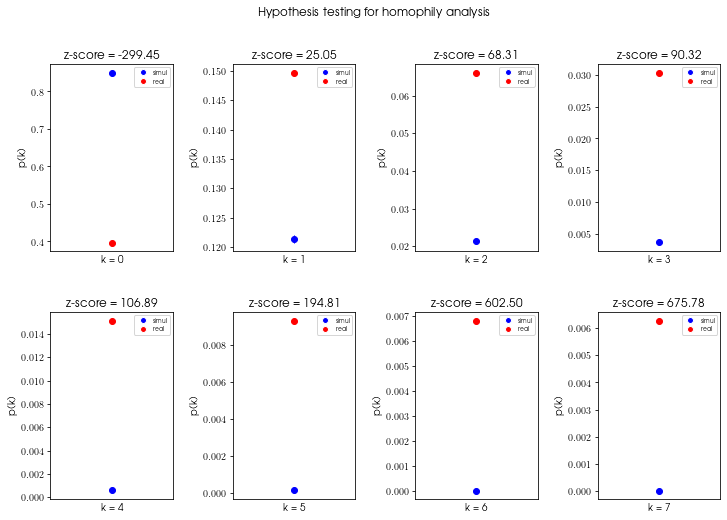

In [57]:
# create figure
fig = plt.figure(figsize=(12, 8))

# populate subplots
spec = gridspec.GridSpec(nrows=3,
                         ncols=7,
                         figure=fig,
                         height_ratios=[0.95, 0.05, 0.95],
                         width_ratios=np.append(np.tile([0.8, 0.18], 3), 0.8))

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 2])
ax2 = fig.add_subplot(spec[0, 4])
ax3 = fig.add_subplot(spec[0, 6])
ax4 = fig.add_subplot(spec[2, 0])
ax5 = fig.add_subplot(spec[2, 2])
ax6 = fig.add_subplot(spec[2, 4])
ax7 = fig.add_subplot(spec[2, 6])

colors = [
    'mediumslateblue', 'mediumblue', 'palevioletred', 'firebrick', 'darkred',
    'red', 'blue', 'yellow'
]

# plot confidence interval for simulated data + point for real data
for i in range(len(k_pk_table)):

    # data series
    x = k_pk_table.loc[i, 'k']
    y = k_pk_table.loc[i, 'simul_mean']
    pk = k_pk_table.loc[i, 'pk']
    z = k_pk_table.loc[i, 'z']
    y_high = k_pk_table.loc[i, 'upper_bound']
    y_low = k_pk_table.loc[i, 'lower_bound']

    # plot simulated data
    col_sim = 'blue'
    var_name = ''.join(['ax', str(i)])
    vars()[var_name].errorbar(x,
                              y,
                              fmt='o',
                              yerr=np.absolute(y_low - y_high) / 2,
                              elinewidth=1,
                              markerfacecolor=col_sim,
                              markeredgecolor=col_sim,
                              ecolor=col_sim)

    # plot real data
    col_real = 'red'
    vars()[var_name].plot(x, pk, 'o', color=col_real)

    label1 = Line2D([0], [0],
                    marker='o',
                    color='w',
                    label='simul',
                    markerfacecolor='blue',
                    markersize=6)
    label2 = Line2D([0], [0],
                    marker='o',
                    color='w',
                    label='real',
                    markerfacecolor='red',
                    markersize=6)

    vars()[var_name].legend(handles=[label1, label2], fontsize=6)

    # set axes and title
    vars()[var_name].tick_params(axis='x', bottom=False, labelbottom=False)
    vars()[var_name].set_xlabel(f'k = {int(x)}')
    vars()[var_name].set_ylabel('p(k)')
    vars()[var_name].set_title('z-score = {0:.2f}'.format(z))

fig.suptitle("Hypothesis testing for homophily analysis")

# save plot
path = os.path.join('output', 'hypo_test.png')
plt.savefig(path)

plt.show()

## Homophily-Performance (Fee) Analysis 

In [58]:
perf_eval_df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992
2,Ajax Amsterdam,Aron Winter,25.0,Defensive Midfield,Lazio,out,1.170,1992
3,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992
4,Willem II Tilburg,Marc Overmars,19.0,Left Winger,Ajax,out,0.817,1992


In [59]:
adj_coef_table.head()

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.784209
4,19.0,0.661457


In [60]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on='age', how='left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'],
                                           perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns=['coef', 'position', 'club_involved_name'], inplace=True)
perf_eval_df.head()

,club_name,player_name,age,transfer_movement,fee_cleaned,year,adjusted_fee
0,Ajax Amsterdam,Marc Overmars,19.0,in,0.817,1992,0.540411
1,Ajax Amsterdam,Jari Litmanen,21.0,in,0.013,1992,0.006954
2,Ajax Amsterdam,Aron Winter,25.0,out,1.170,1992,0.551210
3,Sparta Rotterdam,Winston Bogarde,21.0,in,0.005,1992,0.002674
4,Willem II Tilburg,Marc Overmars,19.0,out,0.817,1992,0.540411


In [61]:
merge_on = ['club_name', 'player_name', 'age', 'transfer_movement', 'fee_cleaned', 'year']
perf_eval_table = pd.merge(df, perf_eval_df, on = merge_on, how = 'left')
perf_eval_table.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[],NaN
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[],NaN
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[],NaN


In [62]:
# only select the players that have at least two transfers to see the improvement
target_player = list(perf_eval_table[perf_eval_table['num_transfer'] > 1]['player_name'])

perf_eval_table = perf_eval_table[perf_eval_table['player_name'].isin(target_player)]
perf_eval_table.reset_index(drop=True, inplace=True)
print(f'number of observation: {len(perf_eval_table)}')
perf_eval_table.head()

number of observation: 66474


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[],NaN
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[],NaN
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[],NaN


In [63]:
# only select transfers that include money transfer
perf_eval_table = perf_eval_table[perf_eval_table['adjusted_fee'].notna()]
print(f'number of observation: {len(perf_eval_table)}')
perf_eval_table.head()

number of observation: 13737


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584
16,Reading FC,Aaron Brown,22.0,Centre-Back,Tamworth,£135Th.,in,0.135,2005,6,9,1.0,[Leroy Lita],0.067819
23,Wolverhampton Wanderers,Aaron Collins,18.0,Centre-Forward,Newport County,£69Th.,in,0.069,2015,1,6,NaN,[],0.054110
29,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,£248Th.,in,0.248,2011,1,2,NaN,[],0.132654


In [64]:
# change in fee as a proxy of performance --> `perf_change`
perf_eval_table['perf_change'] = perf_eval_table.groupby('player_name')['fee_cleaned'].pct_change()

In [65]:
# change in adjusted fee as a proxy of performance --> `perf_change_adjusted`
group = perf_eval_table.groupby('player_name')
perf_eval_table['perf_change_adjusted'] = group['adjusted_fee'].pct_change()

In [66]:
perf_eval_table

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee,perf_change,perf_change_adjusted
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374,NaN,NaN
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584,-0.597222,-0.674288
16,Reading FC,Aaron Brown,22.0,Centre-Back,Tamworth,£135Th.,in,0.135,2005,6,9,1.0,[Leroy Lita],0.067819,NaN,NaN
23,Wolverhampton Wanderers,Aaron Collins,18.0,Centre-Forward,Newport County,£69Th.,in,0.069,2015,1,6,NaN,[],0.054110,NaN,NaN
29,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,£248Th.,in,0.248,2011,1,2,NaN,[],0.132654,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66449,Blackburn Rovers,Zurab Khizanishvili,24.0,Centre-Back,Rangers,£675Th.,in,0.675,2006,2,8,32.0,"[Niklas Gudmundsson, Sergio Peter, Keith Barke...",0.318829,NaN,NaN
66456,Alania Vladikavkaz,Zurab Menteshashvili,22.0,Central Midfield,Skonto Riga,£180k,in,0.180,2002,1,2,NaN,[],0.090426,NaN,NaN
66465,VfL Wolfsburg,Zvjezdan Misimovic,26.0,Attacking Midfield,1.FC Nuremberg,£3.60m,in,3.600,2008,3,4,0.0,[],1.722852,NaN,NaN
66466,Dinamo Moscow,Zvjezdan Misimovic,28.0,Attacking Midfield,Galatasaray,£4.05m,in,4.050,2010,4,4,0.0,[],2.122770,0.125000,0.232125


In [67]:
# get `k-perf` table
k_perf = perf_eval_table[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf.head()

,k,perf_change,perf_change_adjusted
3,1.0,-0.597222,-0.674288
30,1.0,16.258065,14.239675
41,1.0,0.000000,0.051844
54,25.0,4.000000,2.341844
55,1.0,-0.716667,-0.656150


In [68]:
# get average fee change per k
k_perf_plot = pd.DataFrame(
    k_perf.groupby('k')['perf_change_adjusted'].agg(['median',
                                                     'count'])).reset_index()
# use the same k-threshold as homophily analysis
xmax = 7
k_perf_plot = k_perf_plot[k_perf_plot['k'] <= xmax]

In [69]:
k_perf_plot

,k,median,count
0,0.0,0.325797,2862
1,1.0,0.274839,1218
2,2.0,0.191991,507
3,3.0,-0.050725,227
4,4.0,0.049107,107
5,5.0,0.017381,49
6,6.0,-0.231824,32
7,7.0,-0.426467,19


### Visualization

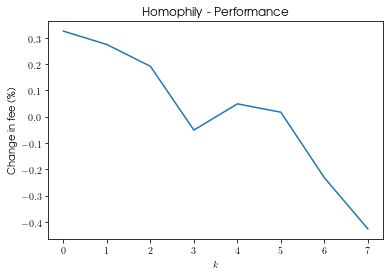

In [70]:
fig, ax = plt.subplots(figsize = (6, 4))

"""Performance-Homophily with age adjustment"""
ax = sns.lineplot(data = k_perf_plot, x = 'k', y = 'median')
ax.set(xlabel='$k$', ylabel = 'Change in fee (\%)')
ax.set_title('Homophily - Performance')

# save plot
path = os.path.join('output', 'homo-perf.png')
plt.savefig(path)

plt.show()

## Tenure Analysis

In [71]:
# prepare table
groupby_keys = list(node_edge_df.columns)

tenure_table = pd.merge(node_edge_df, df, on=groupby_keys, how='outer')

In [72]:
# get unique players
player_list = tenure_table['player_name'].unique()

In [73]:
k_tenure = {}

for player in tqdm(player_list):
    
    # get all transfer by `player`
    temp_df = tenure_table[tenure_table['player_name'] == player]
    
    # get rows that `k` is not null
    target_transfer = temp_df[temp_df['k'].notna()]
    
    # loop
    for i in range(len(target_transfer)):
        
        # get in-transfer info
        
        club = target_transfer['club_name'].iloc[i]
        
        fee = target_transfer['fee_cleaned'].iloc[i]
        
        year_in = target_transfer['year'].iloc[i]
        
        k = target_transfer['k'].iloc[i]
        
        # query for the out-transfer
        
        out_transfer = temp_df.query(f" club_name == '{club}' & transfer_movement == 'out' ")
        
        out_transfer = out_transfer[out_transfer['year'] >= year_in]
        
        # for player who stay in a team until today 
        # (there are also cases that data got loss e.g. Marco Boogers case)
        # we do not want to consider them in tenure analysis 
        # -- the case when player just joined in 2019 or 2020 would be inaccurate if considered
        if len(out_transfer) != 0:
        
            year_out = max(out_transfer[out_transfer['year'] >= year_in]['year'])

            # get tenure (year stayed)

            tenure = year_out - year_in

            # store data

            if k not in k_tenure.keys():

                k_tenure[k] = [tenure]

            elif k in k_tenure.keys():

                k_tenure[k].append(tenure)
                

In [74]:
k_tenure_table = pd.DataFrame(data=zip(k_tenure.keys(),
                                       [np.mean(x) for x in k_tenure.values()]),
                              columns=['k', 'tenure']).sort_values(by='k')

In [75]:
# use the same k-threshold as homophily analysis
xmax = 7
k_tenure_table = k_tenure_table[k_tenure_table['k'] <= xmax]

### Visualization

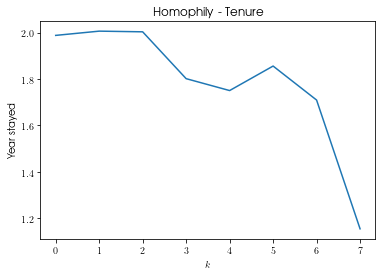

In [76]:
fig, ax = plt.subplots(figsize = (6, 4))

"""Homophily-Tenure Analysis"""
ax = sns.lineplot(data = k_tenure_table, x = 'k', y = 'tenure')
ax.set(xlabel='$k$', ylabel = 'Year stayed')
ax.set_title('Homophily - Tenure')

# save plot
path = os.path.join('output', 'homo-tenure.png')
plt.savefig(path)

plt.show()

## Sample Case

In [77]:
sample_case = pd.merge(node_edge_df, df, on = list(node_edge_df.columns), how = 'left')

In [78]:
zlatan = sample_case[sample_case['player_name'] == 'Zlatan Ibrahimovic']

In [79]:
zlatan

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name
30796,Ajax Amsterdam,Zlatan Ibrahimovic,19.0,Centre-Forward,Malmö FF,£7.02m,in,7.02,2001,1.0,10.0,NaN,[]
44792,Ajax Amsterdam,Zlatan Ibrahimovic,22.0,Centre-Forward,Juventus,£14.40m,out,14.40,2004,NaN,NaN,NaN,NaN
48442,Juventus FC,Zlatan Ibrahimovic,22.0,Centre-Forward,Ajax,£14.40m,in,14.40,2004,2.0,10.0,0.0,[]
61017,FC Internazionale,Zlatan Ibrahimovic,24.0,Centre-Forward,Juventus,£22.32m,in,22.32,2006,3.0,10.0,1.0,[Patrick Vieira]
80511,FC Internazionale,Zlatan Ibrahimovic,27.0,Centre-Forward,FC Barcelona,£62.55m,out,62.55,2009,NaN,NaN,NaN,NaN
83395,FC Barcelona,Zlatan Ibrahimovic,27.0,Centre-Forward,Inter,£62.55m,in,62.55,2009,4.0,10.0,1.0,[Maxwell]
87448,AC Milan,Zlatan Ibrahimovic,28.0,Centre-Forward,FC Barcelona,Loan fee:£5.40m,in,5.40,2010,5.0,10.0,1.0,[Gianluca Zambrotta]
90338,FC Barcelona,Zlatan Ibrahimovic,28.0,Centre-Forward,AC Milan,Loan fee:£5.40m,out,5.40,2010,NaN,NaN,NaN,NaN
94758,AC Milan,Zlatan Ibrahimovic,29.0,Centre-Forward,FC Barcelona,£21.60m,in,21.60,2011,6.0,10.0,18.0,"[Daniele Bonera, Luca Antonini, Kevin-Prince B..."
94810,AC Milan,Zlatan Ibrahimovic,29.0,Centre-Forward,FC Barcelona,"End of loanJun 30, 2011",out,0.00,2011,NaN,NaN,NaN,NaN


In [80]:
adil = sample_case[sample_case['player_name'] == 'Adil Rami']
adil

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name
66456,LOSC Lille,Adil Rami,21.0,Centre-Back,LOSC Lille B,-,in,0.00,2007,1.0,9.0,NaN,[]
93678,LOSC Lille,Adil Rami,25.0,Centre-Back,Valencia,£5.40m,out,5.40,2011,NaN,NaN,NaN,NaN
97319,Valencia CF,Adil Rami,25.0,Centre-Back,LOSC Lille,£5.40m,in,5.40,2011,2.0,9.0,1.0,[Ricardo Costa]
110678,AC Milan,Adil Rami,28.0,Centre-Back,Valencia,Loan fee:£360Th.,in,0.36,2013,3.0,9.0,0.0,[]
112974,Valencia CF,Adil Rami,28.0,Centre-Back,AC Milan,Loan fee:£360Th.,out,0.36,2013,NaN,NaN,NaN,NaN
118134,AC Milan,Adil Rami,28.0,Centre-Back,Valencia,£3.83m,in,3.83,2014,4.0,9.0,15.0,"[Mattia De Sciglio, Daniele Bonera, Keisuke Ho..."
118188,AC Milan,Adil Rami,28.0,Centre-Back,Valencia,"End of loanJun 30, 2014",out,0.00,2014,NaN,NaN,NaN,NaN
120617,Valencia CF,Adil Rami,28.0,Centre-Back,AC Milan,"End of loanJun 30, 2014",in,0.00,2014,5.0,9.0,8.0,"[Juan Carlos, Dani Parejo, Diego Alves, Paco A..."
120625,Valencia CF,Adil Rami,28.0,Centre-Back,AC Milan,£3.83m,out,3.83,2014,NaN,NaN,NaN,NaN
125766,AC Milan,Adil Rami,29.0,Centre-Back,Sevilla FC,£2.25m,out,2.25,2015,NaN,NaN,NaN,NaN


In [81]:
angel = sample_case[sample_case['player_name'] == 'Angel Di Maria']
angel

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name
68317,SL Benfica,Angel Di Maria,19.0,Right Winger,CA Rosario,£7.20m,in,7.2,2007,1.0,4.0,NaN,[]
88551,SL Benfica,Angel Di Maria,22.0,Right Winger,Real Madrid,£29.70m,out,29.7,2010,NaN,NaN,NaN,NaN
90449,Real Madrid,Angel Di Maria,22.0,Right Winger,Benfica,£29.70m,in,29.7,2010,2.0,4.0,0.0,[]
115704,Manchester United,Angel Di Maria,26.0,Right Winger,Real Madrid,£67.50m,in,67.5,2014,3.0,4.0,0.0,[]
120483,Real Madrid,Angel Di Maria,26.0,Right Winger,Man Utd,£67.50m,out,67.5,2014,NaN,NaN,NaN,NaN
123228,Manchester United,Angel Di Maria,27.0,Right Winger,Paris SG,£56.70m,out,56.7,2015,NaN,NaN,NaN,NaN
124031,Paris Saint-Germain,Angel Di Maria,27.0,Right Winger,Man Utd,£56.70m,in,56.7,2015,4.0,4.0,1.0,[David Luiz]


# Top Player Analysis

## Homophily-Performance (Fee) Analysis 

In [82]:
# load top player data from fifa database
top_player_fifa = pd.read_csv(os.path.join(cleaned_data_path, 'top_player_fifa.csv'))

In [83]:
top_player_fifa.head()

,year,overall_rating,player_name,z
0,2015,75.0,Jose Dorado,1.057408
1,2008,78.0,Pablo Hernandez,1.465598
2,2009,79.0,Pablo Hernandez,1.601661
3,2010,81.0,Pablo Hernandez,1.873787
4,2011,81.0,Pablo Hernandez,1.873787


In [84]:
# get a list of top players
top_player_list = top_player_fifa['player_name'].unique()
print(f'Number of players: {len(top_player_list)}')

Number of players: 2816


In [85]:
# filter data
top_player_table = perf_eval_table[perf_eval_table['player_name'].isin(top_player_list)]

In [86]:
print(f'Number of observations: {len(top_player_table)}')
top_player_table.head()

Number of observations: 4397


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee,perf_change,perf_change_adjusted
40,Aston Villa,Aaron Hughes,25.0,Centre-Back,Newcastle,£1.35m,in,1.35,2005,2,5,0.0,[],0.636011,NaN,NaN
41,Fulham FC,Aaron Hughes,27.0,Centre-Back,Aston Villa,£1.35m,in,1.35,2007,3,5,1.0,[Steven Davis],0.668984,0.0,0.051844
46,Hamburger SV,Aaron Hunt,28.0,Attacking Midfield,VfL Wolfsburg,£2.70m,in,2.70,2015,3,3,0.0,[],1.415180,NaN,NaN
51,Tottenham Hotspur,Aaron Lennon,18.0,Right Winger,Leeds,£1.08m,in,1.08,2005,2,6,1.0,[Paul Robinson],0.846946,NaN,NaN
54,Everton FC,Aaron Lennon,28.0,Right Winger,Spurs,£5.40m,in,5.40,2015,5,6,25.0,"[Kevin Mirallas, Arouna Kone, Tony Hibbert, Co...",2.830360,4.0,2.341844


In [87]:
# get `k-perf` table
k_perf = top_player_table[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf.head()

,k,perf_change,perf_change_adjusted
41,1.0,0.000000,0.051844
54,25.0,4.000000,2.341844
55,1.0,-0.716667,-0.656150
199,20.0,-0.030303,0.097202
243,0.0,-0.294118,-0.284806


In [88]:
# get average fee change per k
k_perf_plot = pd.DataFrame(
    k_perf.groupby('k')['perf_change_adjusted'].agg(['median',
                                                     'count'])).reset_index()
# use the same k-threshold as homophily analysis
xmax = 7
k_perf_plot = k_perf_plot[k_perf_plot['k'] <= xmax]

In [89]:
k_perf_plot

,k,median,count
0,0.0,0.534326,1076
1,1.0,0.320919,578
2,2.0,0.373879,250
3,3.0,-0.101470,109
4,4.0,-0.337715,49
5,5.0,-0.093527,30
6,6.0,-0.283508,13
7,7.0,-0.178993,8


### Visualization

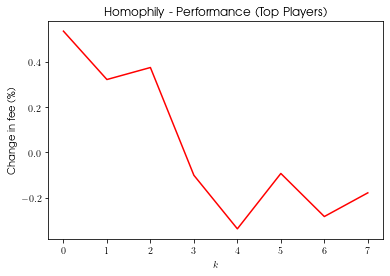

In [90]:
fig, ax = plt.subplots(figsize = (6, 4))

"""Performance-Homophily with age adjustment (For top Players)"""
ax = sns.lineplot(data = k_perf_plot, x = 'k', y = 'median', color = 'red')
ax.set(xlabel='$k$', ylabel = 'Change in fee (\%)')
ax.set_title('Homophily - Performance (Top Players)')

# save plot
path = os.path.join('output', 'top_homo-perf.png')
plt.savefig(path)

plt.show()

## Tenure Analysis

In [91]:
# prepare table
groupby_keys = list(node_edge_df.columns)

tenure_table = pd.merge(node_edge_df, df, on=groupby_keys, how='outer')

In [92]:
tenure_table

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992,1.0,1.0,NaN,[]
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992,1.0,1.0,NaN,[]
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992,1.0,1.0,NaN,[]
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992,1.0,2.0,NaN,[]
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162996,Elche CF,Miguel San Roman,23.0,Goalkeeper,Atl. Madrid B,"End of loanAug 24, 2020",out,0.0,2020,NaN,NaN,NaN,NaN
162997,Elche CF,Andoni Lopez,24.0,Left-Back,Athletic,"End of loanAug 24, 2020",out,0.0,2020,NaN,NaN,NaN,NaN
162998,Elche CF,Dani Escriche,22.0,Centre-Forward,SD Huesca,"End of loanAug 24, 2020",out,0.0,2020,NaN,NaN,NaN,NaN
162999,Villarreal CF,Santiago Caseres,23.0,Defensive Midfield,América,"End of loanDec 31, 2020",in,0.0,2020,2.0,2.0,43.0,"[Samu Chukwueze, Carlos Marchena, Ruben Pena, ..."


In [93]:
# get top player list
top_player_list

array(['Jose Dorado', 'Pablo Hernandez', 'Ruben Perez', ...,
       'Eric Bertrand Bailly', 'Gelson', 'Inaki Williams'], dtype=object)

In [94]:
k_tenure = {}

for player in tqdm(top_player_list):
    
    # get all transfer by `player`
    temp_df = tenure_table[tenure_table['player_name'] == player]
    
    # get rows that `k` is not null
    target_transfer = temp_df[temp_df['k'].notna()]
    
    # loop
    for i in range(len(target_transfer)):
        
        # get in-transfer info
        
        club = target_transfer['club_name'].iloc[i]
        
        fee = target_transfer['fee_cleaned'].iloc[i]
        
        year_in = target_transfer['year'].iloc[i]
        
        k = target_transfer['k'].iloc[i]
        
        # query for the out-transfer
        
        out_transfer = temp_df.query(f" club_name == '{club}' & transfer_movement == 'out' ")
        
        out_transfer = out_transfer[out_transfer['year'] >= year_in]
        
        # for player who stay in a team until today 
        # (there are also cases that data got loss e.g. Marco Boogers case)
        # we do not want to consider them in tenure analysis 
        # -- the case when player just joined in 2019 or 2020 would be inaccurate if considered
        if len(out_transfer) != 0:
        
            year_out = max(out_transfer[out_transfer['year'] >= year_in]['year'])

            # get tenure (year stayed)

            tenure = year_out - year_in

            # store data

            if k not in k_tenure.keys():

                k_tenure[k] = [tenure]

            elif k in k_tenure.keys():

                k_tenure[k].append(tenure)
                

In [95]:
k_tenure_table = pd.DataFrame(data=zip(k_tenure.keys(),
                                       [np.mean(x) for x in k_tenure.values()]),
                              columns=['k', 'tenure']).sort_values(by='k')

In [96]:
k_tenure_table

,k,tenure
3,0.0,2.543073
5,1.0,2.528721
1,2.0,2.552156
4,3.0,2.175000
18,4.0,2.283951
...,...,...
57,74.0,7.000000
71,77.0,0.000000
68,78.0,0.333333
66,79.0,0.000000


In [97]:
# use the same k-threshold as homophily analysis
xmax = 7
k_tenure_table = k_tenure_table[k_tenure_table['k'] <= xmax]

### Visualization

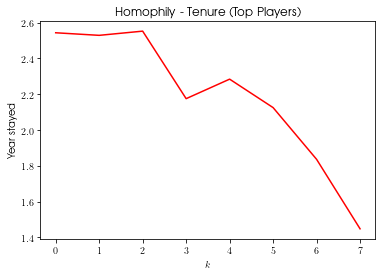

In [98]:
fig, ax = plt.subplots(figsize = (6, 4))

"""Homophily-Tenure Analysis (For top players)"""
ax = sns.lineplot(data = k_tenure_table, x = 'k', y = 'tenure', color = 'red')
ax.set(xlabel='$k$', ylabel = 'Year stayed')
ax.set_title('Homophily - Tenure (Top Players)')

# save plot
path = os.path.join('output', 'top_homo-tenure.png')
plt.savefig(path)

plt.show()